<h1>Residual and Skip Connections</h1>
As we've seen up until now neural networks can learn a lot of interesting things! But much of the data has been of a very simple nature. In this lab we are going to try and train with data that is a bit more complicated, the CIFAR10 dataset. CIFAR10 images are much more complicated then MNIST images and even though they are only 3x32x32 they have about 4x as much data as MNIST! Now imagine using high resolution images!<br>
So let's just bigger neural networks right? In general there are two ways we can increase the size of the neural networks we have seen up until now, by increasing the width (parameters per layer) and the depth (number of layers).<br>
So which is better?<br>
Well..... it's complicated<br>
Via empirical studies it is easy to show that by increasing the model's width the network's performance on a validation set does increase, up until a point then the model with a huge number of parameters starts to overfit on the training set and performance on the validation set DECREASES never reaching even close to 100%. Instead it has been shown that increasing the DEPTH of our model is far more effective. The verdict is STILL out on why this is but theories include:<br>
-Every layer performs independent "operations" (like steps in a program) more steps are better<br>
-Information is "distilled" layer to layer so each layer receives a refined version of the input and so cannot overfit<br>
-Adding a new layer creates more paths for the data to flow to the output then does adding more width

So we'll just add more layers!! Well... it's not that simple

![alt text](https://cdn-images-1.medium.com/max/1000/1*aqmUx_ONo8KqKNEYsjM8eA.png)

[Why ResNets?](https://mc.ai/what-are-deep-residual-networks-or-why-resnets-are-important/)

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from torch.utils.data import DataLoader as dataloader

import os
import random
import numpy as np
import time
import matplotlib.pyplot as plt
from tqdm.notebook import trange, tqdm

from Trainer import ModelTrainer

In [14]:
# The size of our mini batches
batch_size = 256

# How many iterations of our dataset
num_epochs = 30

# Optimizer learning rate
learning_rate = 1e-4

# Initialise best valid accuracy 
best_valid_acc = 0

# Where to load/save the dataset from 
data_set_root = "../../datasets"


In [15]:
start_from_checkpoint = False
save_dir = '../data/Models'

model_name = 'Custom_ResNet_2'

In [16]:
# Set device to GPU_indx if GPU is avaliable
gpu_indx = 0
device = torch.device(gpu_indx if torch.cuda.is_available() else 'cpu')

<h3> Create a transform for the input data </h3>

In [17]:
# Prepare a composition of transforms
# transforms.Compose will perform the transforms in order
# NOTE some transform only take in a PIL image, others only a Tensor
# EG Resize and ToTensor take in a PIL Image, Normalize takes in a Tensor
# Refer to documentation
# https://pytorch.org/docs/stable/torchvision/transforms.html
transform = transforms.Compose([transforms.Resize(32),
                                transforms.ToTensor(),
                                transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                                     std=[0.229, 0.224, 0.225])])

<h3> Create the training, testing and validation data</h3>

In [18]:
# Let's use the CIFAR10 dataset!
train_data = datasets.CIFAR10(data_set_root, train=True, download=True, transform=transform)
test_data = datasets.CIFAR10(data_set_root, train=False, download=True, transform=transform)

# We are going to split the train dataset into a train and validation set
validation_split = 0.9

# Determine the number of samples for each split
n_train_examples = int(len(train_data) * validation_split)
n_valid_examples = len(train_data) - n_train_examples

# The function random_split will take our dataset and split it randomly and give us dataset
# that are the sizes we gave it
# Note: we can split it into to more then two pieces!
train_data, valid_data = torch.utils.data.random_split(train_data, [n_train_examples, n_valid_examples])

<h2>Creating Deep Networks</h2>
So we'll just make our Networks deeper!<br>
Well, it's not that simple, not only does adding more layers mean our model is more sequential (rather than parallel, meaning forward and backward passes are slower) but we now face other problems such as 
<a href="https://towardsdatascience.com/vanishing-gradient-in-deep-neural-network-83953217c59f">Vanishing Gradients</a>. <br>
When we create larger and larger networks, something funny happens when we try and train them, the gradients that are back propagated from the output become tiny (near zero) for layers near the top. They seem to "vanish"! But why!? Well in most models gradients become smaller as they backpropagate through a network. This is easiest to understand by looking at our networks parameters and thinking about how gradients are back propagated. In general gradients are back propagated by multiplying together the weights of layers sequentially. As the weights of our models are tiny (much less then one in magnitude) multiplying many of them together gives us a VERY small result. This problem becomes worse the deeper it is! As a result the top layers of our network barely move from their random initialisations and in effect aren't trained!

<h3>Enter the Skip and Residual Connection!</h3>
Skip and Residual connection allow us to have our deep networks and train them too!<br>
So what are they?<br>
In simple terms we take the output of some layer and "skip" some number of layers and combine it with the hidden layer of a much later layer. One result of this is that, during backpropagation, the gradients have a shorter minimum path to the input layers, reducing the impact of the vanishing gradient!<br>
There are a couple of ways to combine hidden layers together, by adding them together or concatenating the tensors.<br>
Adding the hidden layers together (often called a Residual Connection) means that the size of the layers must be the same which for the networks we've seen until now has not been the case (size usually decreases). However with residual connections we don't necessarily need to add the hidden layers directly. For example, we can take a hidden layer and skip two layers, by passing it through a single layer (that will transform it to the right size) halving the length of the path for gradients.<br>
Concatenating hidden layers involves simply "sticking together" the tensors. <br>
Residual and Skip Connections not only help with the vanishing gradient problem but also helps information from the input penetrate deeper into the network.


![alt text](https://miro.medium.com/max/1140/1*D0F3UitQ2l5Q0Ak-tjEdJg.png)
A simple "Identity" resdual connection

<h3>Modules in Modules</h3>
To simplify the creation of our residual and skip networks we will create seperate nn.modules of the skip and residual "blocks" and then create our "top level" network with these!<br>
NOTE: For simplicity all these blocks return an output the same size as their input though this does not have to be the case! The blocks could downsample/upsample the channels or even the spacial resolution etc! <br>
We also introduce several new basic layer types: <br>
- <a href="https://youtu.be/DtEq44FTPM4?si=7KDVCRr_fzbQ2C7H">Batch Normalisation</a> layers here with Pytorch's <a href="https://pytorch.org/docs/stable/generated/torch.nn.BatchNorm2d.html">nn.BatchNorm2d</a><br>
- Pytorch's <a href="https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html">nn.Sequential</a> module<br>
- <a href="https://youtu.be/ARq74QuavAo?si=n2ukyt4xXAHULaFo">Dropout</a> layers here with Pytorch's <a href="https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html">nn.Dropout</a><br>

In [19]:
# ConvBlock with no Residual connection
class ConvBlock(nn.Module):
    def __init__(self, channels):
        # Call the __init__ function of the parent nn.module class
        super(ConvBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(channels, channels//2,  kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(channels//2)
        self.conv2 = nn.Conv2d(channels//2, channels,  kernel_size=3, stride=1, padding=1)
        
    def forward(self, x):
        x = F.relu(x)
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.conv2(x)
        return x

    
# First block demonstraights a simple identity residual connection
class ResBlock(nn.Module):
    def __init__(self, channels):
        # Call the __init__ function of the parent nn.module class
        super(ResBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(channels, channels//2,  kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(channels//2)
        self.conv2 = nn.Conv2d(channels//2, channels,  kernel_size=3, stride=1, padding=1)
        
    def forward(self, x):
        # Res Skip BEFORE ReLU
        x0 = x 
        
        # Activation function BEFORE Conv Input
        x = F.relu(x)
        
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.conv2(x)
        
        # Res addition on "raw" layer outputs
        return x + x0
    
    
# Second block demonstrates how we can use a "side layer" in our residual block to 
# Change the shape of the tensors so they match later layers
# The channels change in this case but you could also create one where the feature map size changes
class ResDownBlock(nn.Module):
    def __init__(self, channels_in, channels_out=None):
        # Call the __init__ function of the parent nn.module class
        super(ResDownBlock, self).__init__()
        
        if channels_out is None:
            channels_out = channels_in
            
        # How to handle channel width change
        self.conv1 = nn.Conv2d(channels_in, channels_out, kernel_size=3, stride=1, padding = 1)
        self.conv2 = nn.Conv2d(channels_out, channels_out, kernel_size=3, stride=1, padding = 1)
        self.bn1 = nn.BatchNorm2d(channels_out)
        
        self.conv3 = nn.Conv2d(channels_in, channels_out, kernel_size=3, stride=1, padding = 1)

    def forward(self, x):
        x = F.relu(x)
        x0 = self.conv3(x)
        
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.conv2(x)
        
        # Res addition on "raw" layer outputs
        return x + x0

    
# Third block is a simple skip connection
# The layers downsamples to half the input size channel size
# and then concatenates the first hidden layer (x1) to the last output (x1) along the channels
# creating a tensor that is the same shape as the input
class SkipBlock(nn.Module):
    def __init__(self, channels):
        # Call the __init__ function of the parent nn.module class
        super(SkipBlock, self).__init__()
        
        self.conv1 = nn.Conv2d(channels, channels//2,  kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(channels//2)
        self.conv2 = nn.Conv2d(channels//2, channels//2,  kernel_size=3, stride=1, padding=1)
        
    def forward(self, x):
        x = F.relu(x)
        
        x1 = self.conv1(x)
        x2 = F.relu(self.bn1(x1))
        x3 = self.conv2(x2)
        
        # Skip concatenation of "raw" layer outputs
        return torch.cat((x1, x3), 1)

    
# We will use the above blocks to create a "Deep" neural network with many layers!
class Deep_CNN(nn.Module):
    def __init__(self, channels_in, num_blocks=2, ch_width=32, layer_type=ResBlock):
        # Call the __init__ function of the parent nn.module class
        super(Deep_CNN, self).__init__()
        
        # Downsample the image/feature map size from 32x32 to 8x8
        self.conv1 = nn.Conv2d(channels_in, ch_width, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(ch_width)
        
        self.conv2 = nn.Conv2d(ch_width, ch_width, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(ch_width)
        
        self.conv3 = nn.Conv2d(ch_width, ch_width, kernel_size=3, stride=1, padding=1)

        self.maxpool = nn.MaxPool2d(kernel_size=2)

        # Define a nn.Sequential list of ResBlocks if num_blocks > 0
        # else use nn.Identity as a "do nothing" block
        if num_blocks > 0:
            self.layers = self.create_blocks(num_blocks, layer_type, channels=ch_width)
        else:
            self.layers = nn.Identity()

        self.drop_out = nn.Dropout(p=0.5)
        self.linear1 = nn.Linear(ch_width * 4 * 4, 10)

        # This function will create a nn.Sequential block from a list of Pytorch layers
        # A forward pass though the Sequential block will perform a forward pass
        # though the layers in the order they appear in the list
    def create_blocks(self, num_blocks, block_type, channels):
        blocks = []
        
        # We will add some number of the res/skip blocks!
        for _ in range(num_blocks):
            blocks.append(block_type(channels))

        return nn.Sequential(*blocks)
        
    def forward(self, x):
        # Pass input through conv layers
        x = F.relu(self.bn1(self.conv1(x)))
        x = self.maxpool(x)

        x = F.relu(self.bn2(self.conv2(x)))
        x = self.maxpool(x)
        
        # No ReLU on the output so each ResBlock gets the "raw" layer output
        # So the Res skip can happen before any activation function!
        x = self.conv3(x)
        
        # Pass through the block of res/skip blocks!
        x = F.relu(self.layers(x))
        x = self.maxpool(x)

        # Flatten it for the final linear layer!
        x = x.view(x.shape[0], -1)
        
        # Use Drop-out to help prevent overfitting!
        x = self.drop_out(x)
        
        # Ouput the class acitvations!
        x = self.linear1(x)

        return x

<h3>Creating our Network</h3>
When creating an instance of our network we will also specify the type of block we will use!<br>
The next bit of code should be familiar to you, try experimenting with the different layer types and see the different results!

In [20]:
# Create an instance of our network
# Set channels_in to the number of channels of the dataset images
res_net = Deep_CNN(channels_in=3, num_blocks=6, ch_width=32, layer_type=ConvBlock).to(device)

In [21]:
# Lets have a look at our network structure!
# res_net

In [22]:
model_trainer = ModelTrainer(model=res_net, device=device, loss_fun=nn.CrossEntropyLoss(), 
                             batch_size=batch_size, learning_rate=learning_rate, 
                             save_dir=save_dir, model_name=model_name, 
                             start_from_checkpoint=start_from_checkpoint)
valid_acc = 0
train_acc = 0

Starting from scratch


In [23]:
model_trainer.set_data(train_set=train_data, test_set=test_data, val_set=valid_data)

Number of training examples: 45000
Number of validation examples: 5000
Number of testing examples: 10000


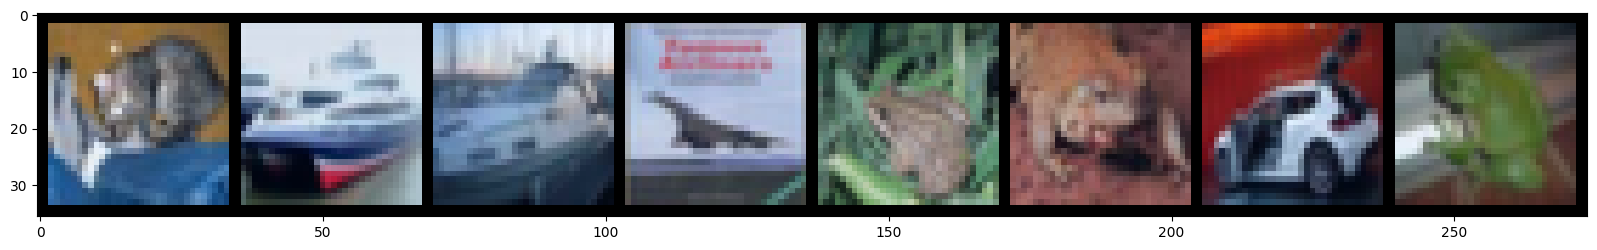

In [24]:
plt.figure(figsize = (20,10))
images, labels = next(iter(model_trainer.test_loader))
out = torchvision.utils.make_grid(images[0:8], normalize=True)
_ = plt.imshow(out.numpy().transpose((1, 2, 0)))

In [25]:
# Lets see how many Parameter's our Model has!
num_params = 0
for param in model_trainer.model.parameters():
    num_params += param.flatten().shape[0]
print("This model has %d (approximately %d Million) Parameters!" % (num_params, num_params//1e6))

This model has 80426 (approximately 0 Million) Parameters!


In [ ]:
# This cell implements our training loop
# Record the start time
start_time = time.time()

pbar = trange(model_trainer.start_epoch, num_epochs, leave=False, desc="Epoch")    
for epoch in pbar:
    pbar.set_postfix_str('Accuracy: Train %.2f%%, Val %.2f%%' % (train_acc * 100, valid_acc * 100))
    
    # Call the training function and pass training dataloader etc
    model_trainer.train_model()
    
    # Call the modules evaluate function for train and validation set
    train_acc = model_trainer.evaluate_model(train_test_val="train")
    valid_acc = model_trainer.evaluate_model(train_test_val="val")
    
    # Check if the current validation accuracy is greater than the previous best
    # If so, then save the model
    if valid_acc > model_trainer.best_valid_acc:
        model_trainer.save_checkpoint(epoch, valid_acc)

end_time = time.time()

Epoch:   0%|          | 0/30 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating Validation Set:   0%|          | 0/20 [00:00<?, ?it/s]

Training:   0%|          | 0/176 [00:00<?, ?it/s]

Evaluating Train Set:   0%|          | 0/176 [00:00<?, ?it/s]

In [ ]:
print("The highest validation accuracy was %.2f%%" %(model_trainer.best_valid_acc*100))

In [ ]:
print("Training time %.2f seconds" %(end_time - start_time))

In [ ]:
_ = plt.figure(figsize = (10, 5))
train_x = np.linspace(0, num_epochs, len(model_trainer.train_loss_logger))
_ = plt.plot(train_x, model_trainer.train_loss_logger)
_ = plt.title("Training Loss")

In [ ]:
_ = plt.figure(figsize = (10,5))
train_x = np.linspace(0, num_epochs, len(model_trainer.train_acc_logger))
_ = plt.plot(train_x, model_trainer.train_acc_logger, c = "y")
valid_x = np.linspace(0, num_epochs, len(model_trainer.val_acc_logger))
_ = plt.plot(valid_x, model_trainer.val_acc_logger, c = "k")

_ = plt.title("Accuracy")
_ = plt.legend(["Training accuracy", "Validation accuracy"])

# Evaluate

In [ ]:
# Call the evaluate function and pass the evaluation/test dataloader etc
test_acc = model_trainer.evaluate_model(train_test_val="test")
print("The Test Accuracy is: %.2f%%" %(test_acc*100))